# AI Fitness Mirror - Pose-Based Activity Recognition

This notebook implements a complete pipeline for:
1. **Pose Estimation**: Extract skeletal keypoints from images/videos using MoveNet Lightning
2. **Activity Classification**: Train a lightweight DNN to classify activities (pushups, situps, etc.)
3. **Pose Correctness Assessment**: Evaluate form quality using learned patterns from correct examples
4. **Real-time Testing**: Test on images, videos, and live webcam feed

## 0. Install Required Libraries

Run this cell first to install all necessary packages.

In [1]:
%pip install opencv-python tensorflow tensorflow-hub numpy matplotlib scikit-learn

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.2 MB/s eta 0:00:00
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)

  Attempting uninstall: protobuf

    Found existing installation: protobuf 3.20.3

    Uninstalling protobuf-3.20.3:

   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [protobuf]
   ---------------------------------------- 0/5 [

The system cannot find the path specified.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.9 requires protobuf<4,>=3.11, but you have protobuf 6.33.4 which is incompatible.


## 1. Import Required Libraries

In [2]:
import cv2
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("TensorFlow Hub available")
print("MoveNet Lightning will be loaded from TensorFlow Hub")


TensorFlow version: 2.20.0
OpenCV version: 4.11.0
TensorFlow Hub available
MoveNet Lightning will be loaded from TensorFlow Hub


## 2. Configure Paths and Parameters

In [3]:
# Directory Configuration
BASE_DIR = Path(r"C:/Users/Jiesheng He/OneDrive/Documents/aifitnessmirror")
TRAINING_DATA_DIR = BASE_DIR / "data/videos"  # Should contain subfolders: pushups, situps, etc.
OUTPUT_DIR = BASE_DIR / "output"
VISUALIZATION_DIR = OUTPUT_DIR / "visualizations"
MODELS_DIR = OUTPUT_DIR / "models"
JSON_OUTPUT_PATH = OUTPUT_DIR / "all_keypoints.json"

# Create output directories
OUTPUT_DIR.mkdir(exist_ok=True)
VISUALIZATION_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# MoveNet Configuration
POSE_CONFIDENCE = 0.3  # Minimum detection confidence for keypoints

# Model Configuration
SEQUENCE_LENGTH = 30  # Number of frames to consider for video sequences
NUM_KEYPOINTS = 17  # MoveNet provides 17 keypoints (COCO format)
KEYPOINT_FEATURES = 3  # x, y, confidence per keypoint
INPUT_SHAPE = NUM_KEYPOINTS * KEYPOINT_FEATURES  # Flattened keypoints (17 * 3 = 51)

# Load MoveNet Lightning model from TensorFlow Hub
print("Loading MoveNet Lightning model...")
movenet_model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = movenet_model.signatures['serving_default']

# MoveNet keypoint indices (COCO format)
KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

print(f"Configuration complete!")
print(f"Training data directory: {TRAINING_DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Visualizations will be saved to: {VISUALIZATION_DIR}")
print(f"MoveNet Lightning model loaded successfully!")
print(f"Using {NUM_KEYPOINTS} keypoints with {KEYPOINT_FEATURES} features each = {INPUT_SHAPE} total features")

Loading MoveNet Lightning model...



Configuration complete!
Training data directory: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\data\videos
Output directory: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output
Visualizations will be saved to: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\visualizations
MoveNet Lightning model loaded successfully!
Using 17 keypoints with 3 features each = 51 total features


## 3. Load and Process Training Data

In [4]:
def load_training_data(data_dir):
    """
    Load images and videos from class-labeled folders
    Expected structure: training_data/pushups/, training_data/situps/, etc.
    Returns: dictionary with activity labels and file paths
    """
    data = {
        'images': {},
        'videos': {},
        'classes': []
    }
    
    if not data_dir.exists():
        print(f"Warning: Training data directory not found: {data_dir}")
        print(f"Please create the directory and add subfolders for each activity class.")
        print(f"Example structure:")
        print(f"  {data_dir}/")
        print(f"    pushups/")
        print(f"      image1.jpg, video1.mp4, ...")
        print(f"    situps/")
        print(f"      image1.jpg, video1.mp4, ...")
        return data
    
    # Supported file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    video_extensions = {'.mp4', '.avi', '.mov', '.mkv'}
    
    # Scan each class folder
    for class_folder in data_dir.iterdir():
        if class_folder.is_dir():
            class_name = class_folder.name
            data['classes'].append(class_name)
            data['images'][class_name] = []
            data['videos'][class_name] = []
            
            # Scan files in class folder
            for file_path in class_folder.iterdir():
                if file_path.suffix.lower() in image_extensions:
                    data['images'][class_name].append(file_path)
                elif file_path.suffix.lower() in video_extensions:
                    data['videos'][class_name].append(file_path)
            
            print(f"Class '{class_name}': {len(data['images'][class_name])} images, {len(data['videos'][class_name])} videos")
    
    return data

# Load training data
training_data = load_training_data(TRAINING_DATA_DIR)
print(f"\nTotal classes found: {len(training_data['classes'])}")
print(f"Classes: {training_data['classes']}")

Class 'hip thrusts': 0 images, 49 videos
Class 'jumping jacks': 0 images, 50 videos
Class 'lunges': 0 images, 55 videos
Class 'pullups': 0 images, 50 videos
Class 'pushups': 0 images, 58 videos
Class 'squats': 0 images, 58 videos

Total classes found: 6
Classes: ['hip thrusts', 'jumping jacks', 'lunges', 'pullups', 'pushups', 'squats']


## 4. Extract Pose Keypoints from Images

In [5]:
def extract_keypoints_from_image(image_path, movenet_model):
    """
    Extract pose keypoints from a single image using MoveNet Lightning
    Returns: keypoints array (17 landmarks x 3 features) or None if no pose detected
    """
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None, None
    
    # Resize and preprocess for MoveNet (192x192 for Lightning)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = tf.image.resize_with_pad(tf.expand_dims(tf.convert_to_tensor(image_rgb), 0), 192, 192)
    input_image = tf.cast(input_image, dtype=tf.int32)
    
    # Run inference
    outputs = movenet_model(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()[0, 0, :, :]
    
    # Check if pose is detected (using average confidence)
    avg_confidence = np.mean(keypoints_with_scores[:, 2])
    if avg_confidence < POSE_CONFIDENCE:
        return None, image
    
    # Flatten keypoints: [y, x, confidence] for each of 17 landmarks -> convert to [x, y, confidence]
    keypoints = []
    for i in range(NUM_KEYPOINTS):
        y, x, conf = keypoints_with_scores[i]
        keypoints.extend([x, y, conf])  # Swap to x, y order
    
    return np.array(keypoints), image

def process_images(image_dict, class_name):
    """
    Process all images for a given class and extract keypoints
    """
    keypoints_data = []
    
    for img_path in image_dict[class_name]:
        keypoints, image = extract_keypoints_from_image(img_path, movenet)
        
        if keypoints is not None:
            keypoints_data.append({
                'file': str(img_path),
                'class': class_name,
                'type': 'image',
                'keypoints': keypoints.tolist(),
                'image': image
            })
    
    print(f"Extracted keypoints from {len(keypoints_data)}/{len(image_dict[class_name])} images for class '{class_name}'")
    return keypoints_data

# Process all image classes
all_image_keypoints = []
for class_name in training_data['classes']:
    if class_name in training_data['images'] and len(training_data['images'][class_name]) > 0:
        class_keypoints = process_images(training_data['images'], class_name)
        all_image_keypoints.extend(class_keypoints)

print(f"\nTotal images processed: {len(all_image_keypoints)}")


Total images processed: 0


## 5. Extract Pose Keypoints from Videos

In [6]:
def extract_keypoints_from_video(video_path, movenet_model, sample_rate=5):
    """
    Extract pose keypoints from video frames using MoveNet Lightning
    sample_rate: process every Nth frame to reduce computation
    Returns: list of keypoint arrays and corresponding frames
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Failed to load video: {video_path}")
        return [], []
    
    keypoints_sequence = []
    frames = []
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Sample frames to reduce processing time
        if frame_count % sample_rate == 0:
            # Preprocess for MoveNet
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_image = tf.image.resize_with_pad(tf.expand_dims(tf.convert_to_tensor(frame_rgb), 0), 192, 192)
            input_image = tf.cast(input_image, dtype=tf.int32)
            
            # Run inference
            outputs = movenet_model(input_image)
            keypoints_with_scores = outputs['output_0'].numpy()[0, 0, :, :]
            
            # Check if pose is detected
            avg_confidence = np.mean(keypoints_with_scores[:, 2])
            if avg_confidence >= POSE_CONFIDENCE:
                # Flatten keypoints: convert [y, x, confidence] to [x, y, confidence]
                keypoints = []
                for i in range(NUM_KEYPOINTS):
                    y, x, conf = keypoints_with_scores[i]
                    keypoints.extend([x, y, conf])
                
                keypoints_sequence.append(np.array(keypoints))
                frames.append(frame)
        
        frame_count += 1
    
    cap.release()
    return keypoints_sequence, frames

def process_videos(video_dict, class_name):
    """
    Process all videos for a given class and extract keypoint sequences
    """
    video_keypoints_data = []
    
    for vid_path in video_dict[class_name]:
        keypoints_seq, frames = extract_keypoints_from_video(vid_path, movenet)
        
        if len(keypoints_seq) > 0:
            video_keypoints_data.append({
                'file': str(vid_path),
                'class': class_name,
                'type': 'video',
                'keypoints_sequence': [kp.tolist() for kp in keypoints_seq],
                'frames': frames,
                'num_frames': len(keypoints_seq)
            })
    
    print(f"Extracted keypoints from {len(video_keypoints_data)}/{len(video_dict[class_name])} videos for class '{class_name}'")
    return video_keypoints_data

# Process all video classes
all_video_keypoints = []
for class_name in training_data['classes']:
    if class_name in training_data['videos'] and len(training_data['videos'][class_name]) > 0:
        class_keypoints = process_videos(training_data['videos'], class_name)
        all_video_keypoints.extend(class_keypoints)

print(f"\nTotal videos processed: {len(all_video_keypoints)}")

Extracted keypoints from 48/49 videos for class 'hip thrusts'
Extracted keypoints from 50/50 videos for class 'jumping jacks'
Extracted keypoints from 55/55 videos for class 'lunges'
Extracted keypoints from 50/50 videos for class 'pullups'
Extracted keypoints from 58/58 videos for class 'pushups'
Extracted keypoints from 57/58 videos for class 'squats'

Total videos processed: 318


## 6. Visualize Skeletal Models on Images

In [7]:
def draw_pose_on_image(image, keypoints):
    """
    Draw skeletal pose overlay on image using MoveNet keypoints (17 keypoints, COCO format)
    """
    annotated_image = image.copy()
    h, w, _ = image.shape
    
    # Convert flat keypoints to landmark format (x, y, confidence)
    landmarks = []
    for i in range(0, len(keypoints), 3):
        x, y, conf = keypoints[i:i+3]
        landmarks.append((int(x * w), int(y * h), conf))
    
    # Define COCO pose connections (17 keypoints)
    # Format: (start_keypoint_index, end_keypoint_index)
    connections = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Face
        (0, 5), (0, 6),  # Face to shoulders
        (5, 7), (7, 9),  # Left arm
        (6, 8), (8, 10),  # Right arm
        (5, 6),  # Shoulders
        (5, 11), (6, 12),  # Shoulders to hips
        (11, 12),  # Hips
        (11, 13), (13, 15),  # Left leg
        (12, 14), (14, 16)  # Right leg
    ]
    
    # Draw connections
    for connection in connections:
        start_idx, end_idx = connection
        if start_idx < len(landmarks) and end_idx < len(landmarks):
            start_point = landmarks[start_idx][:2]
            end_point = landmarks[end_idx][:2]
            if landmarks[start_idx][2] > 0.3 and landmarks[end_idx][2] > 0.3:  # Check confidence
                cv2.line(annotated_image, start_point, end_point, (0, 255, 0), 2)
    
    # Draw keypoints
    for i, (x, y, conf) in enumerate(landmarks):
        if conf > 0.3:
            cv2.circle(annotated_image, (x, y), 5, (0, 0, 255), -1)
    
    return annotated_image

def save_image_visualizations(image_keypoints_data):
    """
    Save skeletal overlays for all processed images
    """
    img_viz_dir = VISUALIZATION_DIR / "images"
    img_viz_dir.mkdir(exist_ok=True)
    
    for i, data in enumerate(image_keypoints_data):
        annotated_image = draw_pose_on_image(data['image'], data['keypoints'])
        
        # Create output filename
        original_name = Path(data['file']).stem
        output_name = f"{data['class']}_{original_name}_pose.jpg"
        output_path = img_viz_dir / output_name
        
        cv2.imwrite(str(output_path), annotated_image)
    
    print(f"Saved {len(image_keypoints_data)} image visualizations to {img_viz_dir}")

# Generate and save image visualizations
if len(all_image_keypoints) > 0:
    save_image_visualizations(all_image_keypoints)
    print("Image visualizations complete!")

## 7. Visualize Skeletal Models on Videos

In [8]:
def save_video_visualizations(video_keypoints_data):
    """
    Create and save videos with skeletal overlays
    """
    vid_viz_dir = VISUALIZATION_DIR / "videos"
    vid_viz_dir.mkdir(exist_ok=True)
    
    for data in video_keypoints_data:
        if len(data['frames']) == 0:
            continue
        
        # Get video properties
        sample_frame = data['frames'][0]
        h, w, _ = sample_frame.shape
        
        # Create output filename
        original_name = Path(data['file']).stem
        output_name = f"{data['class']}_{original_name}_pose.mp4"
        output_path = vid_viz_dir / output_name
        
        # Create video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 6  # Reduced FPS since we sampled frames
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (w, h))
        
        # Process each frame
        for frame, keypoints in zip(data['frames'], data['keypoints_sequence']):
            annotated_frame = draw_pose_on_image(frame, keypoints)
            out.write(annotated_frame)
        
        out.release()
    
    print(f"Saved {len(video_keypoints_data)} video visualizations to {vid_viz_dir}")

# Generate and save video visualizations
if len(all_video_keypoints) > 0:
    save_video_visualizations(all_video_keypoints)
    print("Video visualizations complete!")

Saved 318 video visualizations to C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\visualizations\videos
Video visualizations complete!


## 8. Save Keypoints to JSON

In [9]:
def save_keypoints_to_json(image_data, video_data, output_path):
    """
    Compile all keypoints into a single JSON file following COCO-like format
    """
    json_data = {
        'info': {
            'description': 'AI Fitness Mirror - Pose Keypoints Dataset',
            'version': '1.0',
            'date_created': datetime.now().isoformat(),
            'num_keypoints': NUM_KEYPOINTS,
            'keypoint_format': 'MediaPipe Pose (33 landmarks with x, y, z, visibility)'
        },
        'classes': training_data['classes'],
        'images': [],
        'videos': []
    }
    
    # Add image data
    for i, data in enumerate(image_data):
        json_data['images'].append({
            'id': i,
            'file_path': data['file'],
            'class': data['class'],
            'keypoints': data['keypoints']
        })
    
    # Add video data
    for i, data in enumerate(video_data):
        # Remove frames from JSON (too large), keep only keypoints
        json_data['videos'].append({
            'id': i,
            'file_path': data['file'],
            'class': data['class'],
            'num_frames': data['num_frames'],
            'keypoints_sequence': data['keypoints_sequence']
        })
    
    # Save to file
    with open(output_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"Saved keypoints data to {output_path}")
    print(f"  - Images: {len(json_data['images'])}")
    print(f"  - Videos: {len(json_data['videos'])}")
    print(f"  - Total classes: {len(json_data['classes'])}")

# Save all keypoints to JSON
save_keypoints_to_json(all_image_keypoints, all_video_keypoints, JSON_OUTPUT_PATH)
print("\nJSON file ready for manual verification!")

Saved keypoints data to C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\all_keypoints.json
  - Images: 0
  - Videos: 318
  - Total classes: 6

JSON file ready for manual verification!


## 9. Prepare Dataset for Training

In [10]:
def prepare_training_data(image_data, video_data):
    """
    Convert keypoints to normalized feature vectors for training
    """
    X = []  # Features (keypoints)
    y = []  # Labels (activity classes)
    
    # Process images
    for data in image_data:
        X.append(data['keypoints'])
        y.append(data['class'])
    
    # Process videos - extract individual frames
    for data in video_data:
        for keypoints in data['keypoints_sequence']:
            X.append(keypoints)
            y.append(data['class'])
    
    X = np.array(X)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)
    
    print(f"Dataset prepared:")
    print(f"  - Total samples: {len(X)}")
    print(f"  - Feature shape: {X.shape}")
    print(f"  - Classes: {label_encoder.classes_}")
    print(f"  - Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
    
    return X, y_categorical, label_encoder

# Prepare data
if len(all_image_keypoints) > 0 or len(all_video_keypoints) > 0:
    X_data, y_data, label_encoder = prepare_training_data(all_image_keypoints, all_video_keypoints)
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=np.argmax(y_data, axis=1)
    )
    
    print(f"\nTraining set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    
    # Store for later use
    num_classes = len(label_encoder.classes_)
else:
    print("No training data available. Please add images/videos to the training_data folder.")

Dataset prepared:
  - Total samples: 8506
  - Feature shape: (8506, 51)
  - Classes: ['hip thrusts' 'jumping jacks' 'lunges' 'pullups' 'pushups' 'squats']
  - Class distribution: {'hip thrusts': 1330, 'jumping jacks': 1066, 'lunges': 1239, 'pullups': 1290, 'pushups': 1944, 'squats': 1637}

Training set: 6804 samples
Validation set: 1702 samples


## 10. Build Lightweight DNN Model for Activity Classification

In [11]:
def build_activity_classifier(input_shape, num_classes):
    """
    Build a lightweight DNN for activity classification from pose keypoints
    Uses a simple feedforward network - very efficient for inference
    """
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Dense layers with dropout for regularization
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
if 'num_classes' in locals():
    activity_model = build_activity_classifier(INPUT_SHAPE, num_classes)
    activity_model.summary()
    
    print(f"\nActivity classification model created!")
    print(f"Input: {INPUT_SHAPE} features (33 landmarks × 4 values)")
    print(f"Output: {num_classes} activity classes")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,390 (220.27 KB)

 Trainable params: 55,622 (217.27 KB)

 Non-trainable params: 768 (3.00 KB)


Activity classification model created!
Input: 51 features (33 landmarks × 4 values)
Output: 6 activity classes


## 11. Build Pose Correctness Assessment Model

In [12]:
def build_correctness_autoencoder(input_shape, num_classes):
    """
    Build an autoencoder-based correctness model for each activity class
    The model learns to reconstruct correct poses. Reconstruction error indicates incorrectness.
    Low error = correct form, High error = incorrect form
    
    We create a shared encoder/decoder with class-specific branches
    """
    # Input layer
    input_layer = layers.Input(shape=(input_shape,))
    class_input = layers.Input(shape=(num_classes,))  # One-hot encoded class
    
    # Concatenate keypoints with class information
    combined = layers.Concatenate()([input_layer, class_input])
    
    # Encoder
    encoded = layers.Dense(128, activation='relu')(combined)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)  # Bottleneck
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # Reconstruct only the keypoints (not the class)
    output_layer = layers.Dense(input_shape, activation='linear')(decoded)
    
    # Build model
    model = models.Model(inputs=[input_layer, class_input], outputs=output_layer)
    
    model.compile(
        optimizer='adam',
        loss='mse',  # Mean squared error for reconstruction
        metrics=['mae']
    )
    
    return model

# Build correctness model
if 'num_classes' in locals():
    correctness_model = build_correctness_autoencoder(INPUT_SHAPE, num_classes)
    correctness_model.summary()
    
    print(f"\nCorrectness assessment model created!")
    print(f"This model learns the patterns of CORRECT poses.")
    print(f"Higher reconstruction error = less correct form")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 57)        │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      7,424 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      2,112 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,320 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 51)        │      6,579 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,771 (135.82 KB)

 Trainable params: 34,771 (135.82 KB)

 Non-trainable params: 0 (0.00 B)


Correctness assessment model created!
This model learns the patterns of CORRECT poses.
Higher reconstruction error = less correct form


## 12. Train Activity Classification Model

Training activity classification model...
Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5165 - loss: 1.2363 - val_accuracy: 0.4642 - val_loss: 1.3816 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.8733 - val_accuracy: 0.6986 - val_loss: 0.8126 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 0.8072 - val_accuracy: 0.7374 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6849 - loss: 0.7582 - val_accuracy: 0.7579 - val_loss: 0.6059 - learning_rate: 0.0010
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7014 - loss: 0.7201 - val_accuracy: 0.7797 - val_loss: 0.5231 - learning_rate: 0.0010
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7153 - loss: 0.7052 - val_accuracy: 0.7838 - val_loss: 0.5189 - learning_rate: 0.0010
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━

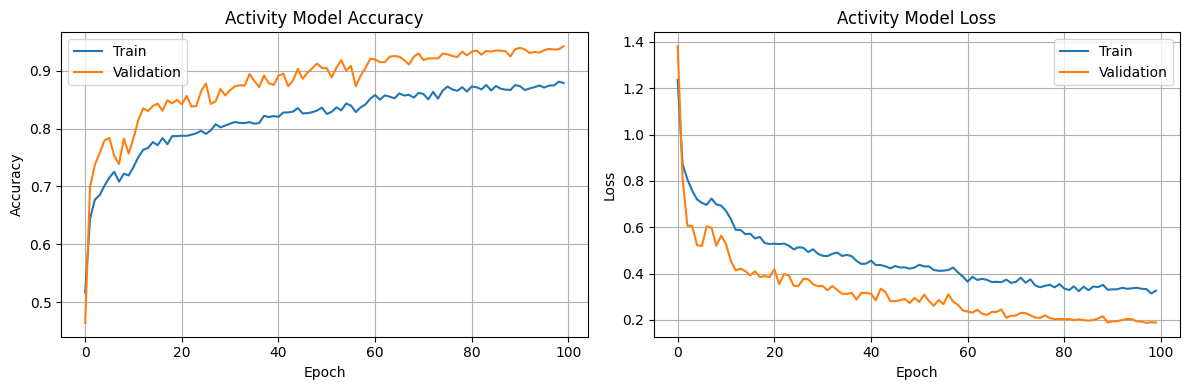

In [13]:
# Train the activity classification model
if 'activity_model' in locals() and 'X_train' in locals():
    print("Training activity classification model...")
    
    # Callbacks for better training
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    )
    
    # Train
    history = activity_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate
    train_loss, train_acc = activity_model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = activity_model.evaluate(X_val, y_val, verbose=0)
    
    print(f"\n{'='*50}")
    print(f"Activity Classification Model Results:")
    print(f"  Training Accuracy: {train_acc*100:.2f}%")
    print(f"  Validation Accuracy: {val_acc*100:.2f}%")
    print(f"{'='*50}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Activity Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Activity Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training - no data available")

## 13. Train Pose Correctness Model

Training pose correctness model...
This model learns to reconstruct CORRECT poses (from training data)
Reconstruction error will be used to assess form quality

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0483 - mae: 0.1661 - val_loss: 0.0189 - val_mae: 0.1073 - learning_rate: 0.0010
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mae: 0.1104 - val_loss: 0.0136 - val_mae: 0.0895 - learning_rate: 0.0010
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0981 - val_loss: 0.0105 - val_mae: 0.0772 - learning_rate: 0.0010
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - mae: 0.0913 - val_loss: 0.0096 - val_mae: 0.0740 - learning_rate: 0.0010
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130 - mae: 0.0872 - val_loss: 0.0086 - val_mae: 0.0696 - learning_rate: 0.0010
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.0837 - val_loss: 0.0083 - val_mae: 0.0679 - lea

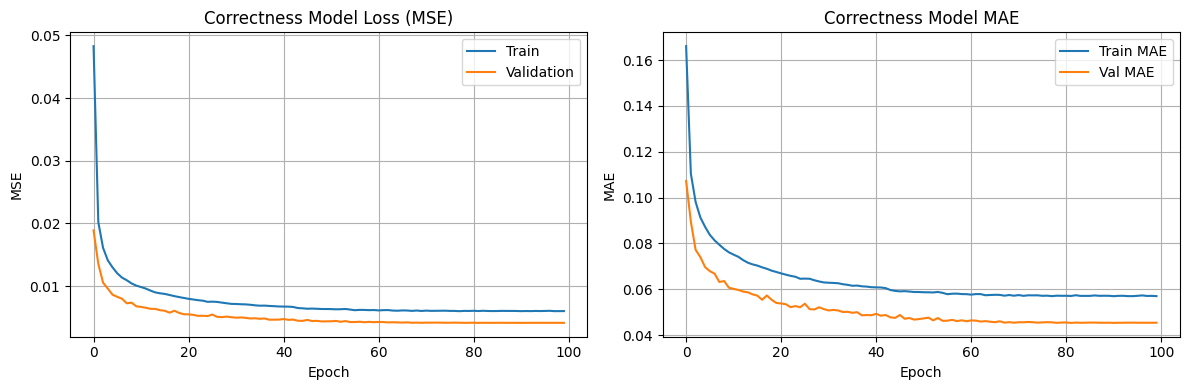

In [14]:
# Train the correctness assessment model
if 'correctness_model' in locals() and 'X_train' in locals():
    print("Training pose correctness model...")
    print("This model learns to reconstruct CORRECT poses (from training data)")
    print("Reconstruction error will be used to assess form quality\n")
    
    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    )
    
    # Train to reconstruct the input keypoints
    # The target is the same as input (autoencoder)
    history_correctness = correctness_model.fit(
        [X_train, y_train], X_train,  # Input: keypoints + class, Output: keypoints
        validation_data=([X_val, y_val], X_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate
    train_loss = correctness_model.evaluate([X_train, y_train], X_train, verbose=0)
    val_loss = correctness_model.evaluate([X_val, y_val], X_val, verbose=0)
    
    print(f"\n{'='*50}")
    print(f"Correctness Assessment Model Results:")
    print(f"  Training MSE: {train_loss[0]:.6f}")
    print(f"  Validation MSE: {val_loss[0]:.6f}")
    print(f"  (Lower MSE = better reconstruction of correct poses)")
    print(f"{'='*50}")
    
    # Calculate baseline reconstruction errors for each class
    print("\nCalculating baseline reconstruction errors per class...")
    class_reconstruction_errors = {}
    
    for class_idx in range(num_classes):
        class_name = label_encoder.classes_[class_idx]
        # Get samples for this class
        class_mask = np.argmax(y_val, axis=1) == class_idx
        if np.sum(class_mask) > 0:
            X_class = X_val[class_mask]
            y_class = y_val[class_mask]
            
            # Predict and calculate MSE
            predictions = correctness_model.predict([X_class, y_class], verbose=0)
            mse_per_sample = np.mean((X_class - predictions) ** 2, axis=1)
            
            # Store mean and std for this class
            class_reconstruction_errors[class_name] = {
                'mean': np.mean(mse_per_sample),
                'std': np.std(mse_per_sample),
                'threshold': np.mean(mse_per_sample) + 2 * np.std(mse_per_sample)  # 2-sigma threshold
            }
            
            print(f"  {class_name}: mean={class_reconstruction_errors[class_name]['mean']:.6f}, "
                  f"threshold={class_reconstruction_errors[class_name]['threshold']:.6f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history_correctness.history['loss'], label='Train')
    plt.plot(history_correctness.history['val_loss'], label='Validation')
    plt.title('Correctness Model Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history_correctness.history['mae'], label='Train MAE')
    plt.plot(history_correctness.history['val_mae'], label='Val MAE')
    plt.title('Correctness Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training - no data available")

## 14. Save Trained Models

In [15]:
# Save models and metadata
if 'activity_model' in locals():
    # Save activity classification model
    activity_model_path = MODELS_DIR / "activity_classifier.h5"
    activity_model.save(activity_model_path)
    print(f"Activity classifier saved to: {activity_model_path}")
    
    # Save correctness model
    correctness_model_path = MODELS_DIR / "correctness_model.h5"
    correctness_model.save(correctness_model_path)
    print(f"Correctness model saved to: {correctness_model_path}")
    
    # Save label encoder and class info
    model_metadata = {
        'classes': label_encoder.classes_.tolist(),
        'num_classes': num_classes,
        'input_shape': INPUT_SHAPE,
        'num_keypoints': NUM_KEYPOINTS,
        'class_reconstruction_errors': class_reconstruction_errors if 'class_reconstruction_errors' in locals() else {}
    }
    
    metadata_path = MODELS_DIR / "model_metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(model_metadata, f, indent=2)
    print(f"Model metadata saved to: {metadata_path}")
    
    # Try to save as TensorFlow Lite for mobile deployment (optional)
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
        
        tflite_path = MODELS_DIR / "activity_classifier.tflite"
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TensorFlow Lite model saved to: {tflite_path}")
    except Exception as e:
        print(f"Could not convert to TFLite: {e}")
    
    print("\n✓ All models saved successfully!")
else:
    print("No models to save")

Activity classifier saved to: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\models\activity_classifier.h5
Correctness model saved to: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\models\correctness_model.h5
Model metadata saved to: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\models\model_metadata.json
INFO:tensorflow:Assets written to: C:\temp\tmp8eg9gdyv\assets


INFO:tensorflow:Assets written to: C:\temp\tmp8eg9gdyv\assets


Saved artifact at 'C:\temp\tmp8eg9gdyv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 51), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  1543509215952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509217296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509217680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509218640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509217872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509218256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509217488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509216912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509219792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1543509219600: TensorSpec(shape=(), dtyp

## 15. Test on Single Image

Test the trained models on a new image to classify the activity and assess pose correctness.

In [16]:
def test_on_image(image_path, activity_model, correctness_model, label_encoder, class_errors):
    """
    Test trained models on a single image
    """
    # Extract keypoints using MoveNet
    keypoints, image = extract_keypoints_from_image(image_path, movenet)
    
    if keypoints is None:
        print("No pose detected in image!")
        return
    
    # Reshape for prediction
    keypoints_input = keypoints.reshape(1, -1)
    
    # Predict activity
    activity_probs = activity_model.predict(keypoints_input, verbose=0)[0]
    predicted_class_idx = np.argmax(activity_probs)
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = activity_probs[predicted_class_idx]
    
    # Assess correctness
    class_one_hot = to_categorical([predicted_class_idx], num_classes=len(label_encoder.classes_))
    reconstructed = correctness_model.predict([keypoints_input, class_one_hot], verbose=0)
    reconstruction_error = np.mean((keypoints_input - reconstructed) ** 2)
    
    # Calculate correctness score
    if predicted_class in class_errors:
        threshold = class_errors[predicted_class]['threshold']
        correctness_score = max(0, min(100, 100 * (1 - reconstruction_error / threshold)))
    else:
        correctness_score = 50  # Default if no baseline
    
    # Visualize
    annotated_image = draw_pose_on_image(image, keypoints)
    
    # Add text annotations
    h, w, _ = annotated_image.shape
    cv2.putText(annotated_image, f"Activity: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"Confidence: {confidence*100:.1f}%", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"Form Quality: {correctness_score:.1f}%", (10, 110),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} | Confidence: {confidence*100:.1f}% | Form: {correctness_score:.1f}%")
    plt.show()
    
    print(f"\nResults:")
    print(f"  Activity: {predicted_class}")
    print(f"  Confidence: {confidence*100:.1f}%")
    print(f"  Form Quality Score: {correctness_score:.1f}%")
    print(f"  Reconstruction Error: {reconstruction_error:.6f}")

# Example usage (replace with your test image path)
TEST_IMAGE_PATH = BASE_DIR / "test_image.jpg"

if 'activity_model' in locals() and TEST_IMAGE_PATH.exists():
    print(f"Testing on image: {TEST_IMAGE_PATH}")
    test_on_image(TEST_IMAGE_PATH, activity_model, correctness_model, 
                  label_encoder, class_reconstruction_errors)
else:
    print(f"To test on an image, place a test image at: {TEST_IMAGE_PATH}")
    print("Or modify TEST_IMAGE_PATH variable to point to your test image")

To test on an image, place a test image at: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\test_image.jpg
Or modify TEST_IMAGE_PATH variable to point to your test image


## 16. Test on Single Video

Process a test video and generate annotated output with activity classification and form assessment.

In [22]:
def test_on_video(video_path, activity_model, correctness_model, label_encoder, class_errors, output_path=None):
    """
    Test trained models on a video file
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate adaptive text scaling based on video dimensions
    # Base scale on height (assuming 720p as baseline)
    scale_factor = height / 720.0
    font_scale = max(0.4, min(1.2, 0.5 * scale_factor))  # Clamp between 0.4 and 1.2
    font_thickness = max(1, int(2 * scale_factor))
    
    # Calculate text positions and spacing
    text_x = int(10 * scale_factor)
    text_y_start = int(30 * scale_factor)
    text_spacing = int(35 * scale_factor)
    
    # Background rectangle dimensions
    bg_width = int(400 * scale_factor)
    bg_height = int(120 * scale_factor)
    
    # Create output video writer if path provided
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    frame_count = 0
    predictions_log = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocess for MoveNet
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_image = tf.image.resize_with_pad(tf.expand_dims(tf.convert_to_tensor(frame_rgb), 0), 192, 192)
        input_image = tf.cast(input_image, dtype=tf.int32)
        
        # Run inference
        outputs = movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()[0, 0, :, :]
        
        # Check if pose is detected
        avg_confidence = np.mean(keypoints_with_scores[:, 2])
        
        if avg_confidence >= POSE_CONFIDENCE:
            # Extract keypoints
            keypoints = []
            for i in range(NUM_KEYPOINTS):
                y, x, conf = keypoints_with_scores[i]
                keypoints.extend([x, y, conf])
            keypoints = np.array(keypoints)
            
            # Predict activity
            keypoints_input = keypoints.reshape(1, -1)
            activity_probs = activity_model.predict(keypoints_input, verbose=0)[0]
            predicted_class_idx = np.argmax(activity_probs)
            predicted_class = label_encoder.classes_[predicted_class_idx]
            confidence = activity_probs[predicted_class_idx]
            
            # Assess correctness
            class_one_hot = to_categorical([predicted_class_idx], num_classes=len(label_encoder.classes_))
            reconstructed = correctness_model.predict([keypoints_input, class_one_hot], verbose=0)
            reconstruction_error = np.mean((keypoints_input - reconstructed) ** 2)
            
            if predicted_class in class_errors:
                threshold = class_errors[predicted_class]['threshold']
                correctness_score = max(0, min(100, 100 * (1 - reconstruction_error / threshold)))
            else:
                correctness_score = 50
            
            # Draw pose and annotations
            annotated_frame = draw_pose_on_image(frame, keypoints)
            
            # Add semi-transparent background for better text visibility
            overlay = annotated_frame.copy()
            cv2.rectangle(overlay, (text_x - 5, text_y_start - int(25 * scale_factor)), 
                         (text_x + bg_width, text_y_start + bg_height), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.6, annotated_frame, 0.4, 0, annotated_frame)
            
            # Add scaled text annotations
            cv2.putText(annotated_frame, f"Activity: {predicted_class}", 
                       (text_x, text_y_start),
                       cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)
            cv2.putText(annotated_frame, f"Confidence: {confidence*100:.1f}%", 
                       (text_x, text_y_start + text_spacing),
                       cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)
            cv2.putText(annotated_frame, f"Form: {correctness_score:.1f}%", 
                       (text_x, text_y_start + 2 * text_spacing),
                       cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), font_thickness)
            
            # Log prediction
            predictions_log.append({
                'frame': frame_count,
                'activity': predicted_class,
                'confidence': float(confidence),
                'form_score': float(correctness_score)
            })
            
            if output_path:
                out.write(annotated_frame)
        
        frame_count += 1
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames...")
    
    cap.release()
    if output_path:
        out.release()
        print(f"Output video saved to: {output_path}")
    
    # Print summary
    if predictions_log:
        print(f"\nVideo Analysis Summary:")
        print(f"  Total frames processed: {frame_count}")
        print(f"  Frames with pose detected: {len(predictions_log)}")
        
        # Most common activity
        activities = [p['activity'] for p in predictions_log]
        most_common = max(set(activities), key=activities.count)
        print(f"  Most common activity: {most_common}")
        
        # Average form score
        avg_form = np.mean([p['form_score'] for p in predictions_log])
        print(f"  Average form quality: {avg_form:.1f}%")

# Example usage
TEST_VIDEO_PATH = r"C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\test\ezgif-6a50d0e82efce2b3.mp4"
OUTPUT_VIDEO_PATH = OUTPUT_DIR / "test_video_annotated.mp4"

if 'activity_model' in locals() and Path(TEST_VIDEO_PATH).exists():
    print(f"Testing on video: {TEST_VIDEO_PATH}")
    test_on_video(TEST_VIDEO_PATH, activity_model, correctness_model, 
                  label_encoder, class_reconstruction_errors, OUTPUT_VIDEO_PATH)
else:
    print(f"To test on a video, place a test video at: {TEST_VIDEO_PATH}")
    print("Or modify TEST_VIDEO_PATH variable to point to your test video")

Testing on video: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\test\ezgif-6a50d0e82efce2b3.mp4
Processed 30 frames...
Output video saved to: C:\Users\Jiesheng He\OneDrive\Documents\aifitnessmirror\output\test_video_annotated.mp4

Video Analysis Summary:
  Total frames processed: 51
  Frames with pose detected: 51
  Most common activity: pullups
  Average form quality: 58.6%


## 17. Test on Live Video Feed

Real-time activity recognition and form assessment using webcam feed.

In [ ]:
def test_live_feed(activity_model, correctness_model, label_encoder, class_errors):
    """
    Real-time activity recognition and form assessment using webcam
    Press 'q' to quit
    """
    cap = cv2.VideoCapture(0)  # 0 for default webcam
    
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    print("Starting live feed...")
    print("Press 'q' to quit")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Flip frame for mirror effect
        frame = cv2.flip(frame, 1)
        
        # Preprocess for MoveNet
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_image = tf.image.resize_with_pad(tf.expand_dims(tf.convert_to_tensor(frame_rgb), 0), 192, 192)
        input_image = tf.cast(input_image, dtype=tf.int32)
        
        # Run inference
        outputs = movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()[0, 0, :, :]
        
        # Check if pose is detected
        avg_confidence = np.mean(keypoints_with_scores[:, 2])
        
        if avg_confidence >= POSE_CONFIDENCE:
            # Extract keypoints
            keypoints = []
            for i in range(NUM_KEYPOINTS):
                y, x, conf = keypoints_with_scores[i]
                keypoints.extend([x, y, conf])
            keypoints = np.array(keypoints)
            
            # Predict activity
            keypoints_input = keypoints.reshape(1, -1)
            activity_probs = activity_model.predict(keypoints_input, verbose=0)[0]
            predicted_class_idx = np.argmax(activity_probs)
            predicted_class = label_encoder.classes_[predicted_class_idx]
            confidence = activity_probs[predicted_class_idx]
            
            # Assess correctness
            class_one_hot = to_categorical([predicted_class_idx], num_classes=len(label_encoder.classes_))
            reconstructed = correctness_model.predict([keypoints_input, class_one_hot], verbose=0)
            reconstruction_error = np.mean((keypoints_input - reconstructed) ** 2)
            
            if predicted_class in class_errors:
                threshold = class_errors[predicted_class]['threshold']
                correctness_score = max(0, min(100, 100 * (1 - reconstruction_error / threshold)))
            else:
                correctness_score = 50
            
            # Draw pose
            annotated_frame = draw_pose_on_image(frame, keypoints)
            
            # Add larger, more visible text
            h, w, _ = annotated_frame.shape
            
            # Background rectangles for better text visibility
            cv2.rectangle(annotated_frame, (5, 5), (400, 130), (0, 0, 0), -1)
            
            # Text overlays
            cv2.putText(annotated_frame, f"Activity: {predicted_class}", (10, 35),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            cv2.putText(annotated_frame, f"Confidence: {confidence*100:.1f}%", (10, 70),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            
            # Color-coded form quality
            form_color = (0, 255, 0) if correctness_score >= 70 else (0, 165, 255) if correctness_score >= 50 else (0, 0, 255)
            cv2.putText(annotated_frame, f"Form Quality: {correctness_score:.1f}%", (10, 105),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, form_color, 2)
            
            # Show all class probabilities
            y_offset = 160
            cv2.rectangle(annotated_frame, (w - 305, 5), (w - 5, y_offset + len(label_encoder.classes_) * 35), (0, 0, 0), -1)
            cv2.putText(annotated_frame, "Probabilities:", (w - 300, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
            for i, class_name in enumerate(label_encoder.classes_):
                prob = activity_probs[i]
                cv2.putText(annotated_frame, f"{class_name}: {prob*100:.1f}%", 
                           (w - 300, y_offset + i * 35),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            
            frame = annotated_frame
        else:
            # No pose detected
            cv2.putText(frame, "No pose detected", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Display
        cv2.imshow('AI Fitness Mirror - Live Feed (Press Q to quit)', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("Live feed stopped")

# Run live feed test
if 'activity_model' in locals():
    print("\n" + "="*60)
    print("Ready to start live video feed test!")
    print("="*60)
    print("\nUncomment the line below to start the webcam feed:")
    print("test_live_feed(activity_model, correctness_model, label_encoder, class_reconstruction_errors)")
    print("\nNote: The webcam window will open. Press 'q' to quit.")
    
    # Uncomment the next line to run the live feed
    # test_live_feed(activity_model, correctness_model, label_encoder, class_reconstruction_errors)
else:
    print("Models not trained yet. Please train the models first.")

## Summary and Next Steps

**What this notebook does:**
1. ✅ Extracts pose keypoints from images/videos using **MoveNet Lightning** (17 keypoints, COCO format)
2. ✅ Generates skeletal visualizations saved to separate folders
3. ✅ Saves all keypoints to a single JSON file for verification
4. ✅ Trains a lightweight DNN to classify activities (pushups, situps, etc.)
5. ✅ Trains a correctness model that learns from correct examples (no manual labeling needed)
6. ✅ Tests on single images, videos, and live webcam feed

**MoveNet Lightning Benefits:**
- **Lightweight**: ~1.5MB model size (vs 100MB+ MediaPipe)
- **Fast**: Optimized for mobile and edge devices
- **Edge-ready**: Can be converted to TFLite INT8 for deployment on Nuvoton M55
- **Efficient**: 17 keypoints (51 features) vs MediaPipe's 33 keypoints (132 features)

**To get started:**
1. Create a `training_data` folder with subfolders for each activity class:
   ```
   training_data/
   ├── pushups/
   │   ├── image1.jpg
   │   └── video1.mp4
   ├── situps/
   │   ├── image1.jpg
   │   └── video1.mp4
   └── squats/
       └── ...
   ```
2. Run all cells in order
3. Check the `output/visualizations` folder for skeletal overlays
4. Check `output/all_keypoints.json` for extracted data
5. Test the models using the test cells

**Key Features:**
- **Lightweight**: Uses simple feedforward neural networks for fast inference
- **No manual labeling for correctness**: The autoencoder learns what correct form looks like
- **Real-time capable**: Can process live webcam feed
- **Flexible**: Works with images, videos, and live streams
- **Edge-deployable**: Models can be quantized to INT8 for embedded deployment